# Genre Classification with GTZAN 

In [1]:
!pip install torchaudio==0.9.0
import torch #1.9.0
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
SR=16000
eps = 1e-6 #epsilon. Log(0)을 막기 위해 사용하는 수. torch.log(x+eps)
DEV = 'cpu' #device
torch.set_printoptions(sci_mode=False)

     |████████████████████████████████| 1.9 MB 8.1 MB/s 


### Download Dataset
- wget is a command for download a file from URL

In [2]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz


--2021-10-04 04:22:34--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  3.15MB/s    in 6m 10s  

2021-10-04 04:28:46 (3.16 MB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



### Unzip Dataset

In [ ]:
!tar -xvzf genres.tar.gz

### Downsample and Save in PyTorch file
- 전체 파일을 하나씩 불러서 다운샘플링을 한 뒤 저장하는 것
  - 어떻게 하면 전체 파일을 다 불러올 수 있을까

In [5]:
from pathlib import Path

#### Path란 무엇일까

In [8]:
dir_path = 'genres'
blues_path = dir_path + '/blues'
blues_path

'genres/blues'

In [9]:
dir_path = Path('genres/')
dir_path

PosixPath('genres')

In [14]:
file_path = dir_path / 'blues' / 'blues.00100.wav'
file_path

PosixPath('genres/blues/blues.00100.wav')

In [15]:
file_path.exists()

False

In [19]:
k_pop_path = dir_path/'k_pop'
k_pop_path.exists()

True

In [18]:
k_pop_path.mkdir()

### genres 안에 있는 모든 wav파일의 목록을 찾아보자

In [22]:
wav_paths = dir_path.rglob('*.wav')
wav_paths

<generator object Path.rglob at 0x7f8a440e26d0>

#### generator가 무엇인가
- for loop을 돌렸을 때 list와 거의 똑같이 행동한ㄷ

In [23]:
wav_paths_list = list(wav_paths)
for wav in wav_paths_list:
  print(f'List: {wav}')
for wav in wav_paths:
  print(f'Generator: {wav}')

List: genres/jazz/jazz.00014.wav
List: genres/jazz/jazz.00082.wav
List: genres/jazz/jazz.00061.wav
List: genres/jazz/jazz.00032.wav
List: genres/jazz/jazz.00004.wav
List: genres/jazz/jazz.00018.wav
List: genres/jazz/jazz.00053.wav
List: genres/jazz/jazz.00043.wav
List: genres/jazz/jazz.00065.wav
List: genres/jazz/jazz.00086.wav
List: genres/jazz/jazz.00023.wav
List: genres/jazz/jazz.00020.wav
List: genres/jazz/jazz.00041.wav
List: genres/jazz/jazz.00081.wav
List: genres/jazz/jazz.00094.wav
List: genres/jazz/jazz.00034.wav
List: genres/jazz/jazz.00038.wav
List: genres/jazz/jazz.00003.wav
List: genres/jazz/jazz.00068.wav
List: genres/jazz/jazz.00012.wav
List: genres/jazz/jazz.00083.wav
List: genres/jazz/jazz.00046.wav
List: genres/jazz/jazz.00078.wav
List: genres/jazz/jazz.00007.wav
List: genres/jazz/jazz.00027.wav
List: genres/jazz/jazz.00092.wav
List: genres/jazz/jazz.00055.wav
List: genres/jazz/jazz.00095.wav
List: genres/jazz/jazz.00087.wav
List: genres/jazz/jazz.00002.wav
List: genr

In [24]:
wav_paths = dir_path.rglob('*.wav')
for wav in wav_paths:
  print(f'Generator: {wav}')

Generator: genres/jazz/jazz.00014.wav
Generator: genres/jazz/jazz.00082.wav
Generator: genres/jazz/jazz.00061.wav
Generator: genres/jazz/jazz.00032.wav
Generator: genres/jazz/jazz.00004.wav
Generator: genres/jazz/jazz.00018.wav
Generator: genres/jazz/jazz.00053.wav
Generator: genres/jazz/jazz.00043.wav
Generator: genres/jazz/jazz.00065.wav
Generator: genres/jazz/jazz.00086.wav
Generator: genres/jazz/jazz.00023.wav
Generator: genres/jazz/jazz.00020.wav
Generator: genres/jazz/jazz.00041.wav
Generator: genres/jazz/jazz.00081.wav
Generator: genres/jazz/jazz.00094.wav
Generator: genres/jazz/jazz.00034.wav
Generator: genres/jazz/jazz.00038.wav
Generator: genres/jazz/jazz.00003.wav
Generator: genres/jazz/jazz.00068.wav
Generator: genres/jazz/jazz.00012.wav
Generator: genres/jazz/jazz.00083.wav
Generator: genres/jazz/jazz.00046.wav
Generator: genres/jazz/jazz.00078.wav
Generator: genres/jazz/jazz.00007.wav
Generator: genres/jazz/jazz.00027.wav
Generator: genres/jazz/jazz.00092.wav
Generator: g

generator object는 한번 loop을 다 돌면 더 이상 아무것도 반환하지 않는다

In [25]:
for wav in wav_paths:
  print(f'Generator: {wav}')

In [27]:
# 웨이브 파일 개수 확인
len(wav_paths_list)

1000

In [28]:
# 파일을 열고
# 다운샘플링을 하고
# 다운샘플링된 데이터를 저장하자
wav_path = wav_paths_list[0]
torchaudio.load(wav_path)

(tensor([[-0.1553, -0.2125, -0.0863,  ..., -0.0490, -0.0569, -0.0592]]), 22050)

In [29]:
??torchaudio.load

In [31]:
audio_sample_tensor, sample_rate = torchaudio.load(wav_path)
print(audio_sample_tensor.shape, sample_rate)
# shape을 보면 오디오가 모노 사운드 (1채널, 좌우구분 없음)라는 걸 알 수 있음


torch.Size([1, 661794]) 22050


In [38]:
ipd.Audio(audio_sample_tensor, rate=sample_rate)

In [33]:
#다운샘플링
??torchaudio.transforms.Resample
# 변수 명이 대문자로 시작한다는 것은 class라는 것을 의미

In [34]:
# 에러가 남
torchaudio.transforms.Resample(audio_sample_tensor)

ValueError: ignored

In [42]:
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=SR)

In [43]:
downsampled_audio_tensor = resampler(audio_sample_tensor)
ipd.Audio(downsampled_audio_tensor, rate=SR)

In [44]:
audio_sample_tensor.shape, downsampled_audio_tensor.shape

(torch.Size([1, 661794]), torch.Size([1, 480214]))

In [47]:
# 길이 확인하기
print(audio_sample_tensor.shape[1] / sample_rate)
print(downsampled_audio_tensor.shape[1] / SR)

30.013333333333332
30.013375


In [53]:
# downsampled_audio_tensor 저장하기
# torch.Tensor
# torch.save(downsampled_audio_tensor, file_)

# 어떻게 저장할 이름을 정할 것인가
# 원래 데이터의 이름을 사용해서-
print(wav_path)
print(f'Stem is {wav_path.stem}')
print(f'Parent is {wav_path.parent}')
print(f'Name is {wav_path.name}')
new_path = wav_path.stem + '_downsampled.pt'
print(new_path)
torch.save(downsampled_audio_tensor, new_path)

genres/jazz/jazz.00014.wav
Stem is jazz.00014
Parent is genres/jazz
Name is jazz.00014.wav
jazz.00014_downsampled.pt


In [54]:
# 원본 wav와 같은 폴더에 저장
new_path = wav_path.parent / (wav_path.stem + '_downsampled.pt')
torch.save(downsampled_audio_tensor, new_path)

In [59]:
# 1채널에서 채널 정보 삭제
# view 함수: 텐서 안에 있는 정보의 순서와 구조를 바꿔줌
# -1은 주어진 디멘션의 row 개수를 자동으로 계산해달라라는 의미

print(downsampled_audio_tensor.shape)
downsampled_audio_tensor = downsampled_audio_tensor.view(-1)
print(downsampled_audio_tensor.shape)
downsampled_audio_tensor = downsampled_audio_tensor.view(-1, 1)
print(downsampled_audio_tensor.shape)

downsampled_audio_tensor = downsampled_audio_tensor.view(480214, 1)
print(downsampled_audio_tensor.shape)

downsampled_audio_tensor = downsampled_audio_tensor.view(-1, 2)
print(downsampled_audio_tensor.shape)
downsampled_audio_tensor = downsampled_audio_tensor.view(240107, 2)
print(downsampled_audio_tensor.shape)
downsampled_audio_tensor = downsampled_audio_tensor.view(-1)


torch.Size([240107, 2])
torch.Size([480214])
torch.Size([480214, 1])
torch.Size([480214, 1])
torch.Size([240107, 2])
torch.Size([240107, 2])


In [64]:
test = downsampled_audio_tensor[:10]
print(test)
print(test.view(2,5))
print(test.view(5,2))
print(test.view(1,-1))

tensor([-0.1510, -0.1764, -0.0232, -0.0096, -0.0099,  0.0245,  0.0352, -0.0234,
        -0.1167, -0.1371])
tensor([[-0.1510, -0.1764, -0.0232, -0.0096, -0.0099],
        [ 0.0245,  0.0352, -0.0234, -0.1167, -0.1371]])
tensor([[-0.1510, -0.1764],
        [-0.0232, -0.0096],
        [-0.0099,  0.0245],
        [ 0.0352, -0.0234],
        [-0.1167, -0.1371]])
tensor([[-0.1510, -0.1764, -0.0232, -0.0096, -0.0099,  0.0245,  0.0352, -0.0234,
         -0.1167, -0.1371]])


In [65]:
# squeeze는 num_row==1인 dim을 모두 없애준다
print(downsampled_audio_tensor.squeeze())

tensor([-0.1510, -0.1764, -0.0232,  ..., -0.0471, -0.0630, -0.0282])


In [66]:
# 같은 작업을 모든 파일에 대해서 수행한다.
resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=SR)
for wav in wav_paths_list:
  audio_tensor, orig_sample_rate = torchaudio.load(wav)
  # resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=SR)
  # 이 데이터셋의 모든 웨이브 파일의 샘플레이트가 22050 라는 걸 알기 때문에 고정한 걸 그대로 사용
  downsampled_audio = resampler(audio_tensor)
  # 1채널이기 때문에 채널 정보를 그냥 삭제
  downsampled_audio = downsampled_audio.view(-1) 
  # downsampled_audio = downsampled_audio.squeeze()
  new_path = wav.parent / (wav.stem + '_downsampled.pt')
  torch.save(downsampled_audio, new_path)


## 1. Define Dataset and Dataloader
- torch 

In [4]:
from torch.utils.data import Dataset, DataLoader

In [69]:
dataset_dir = Path('genres/')
pt_paths = dataset_dir.rglob('*.pt')
test = [ torch.load(pt_fn) for pt_fn in pt_paths ]

In [71]:
ipd.Audio(test[1], rate=SR)

In [77]:
# 어떻게 장르 이름을 저장할 것인가 (파일 이름을 이용해서)
pt_paths = dataset_dir.rglob('*.pt')
test_fn = next(pt_paths)
print(test_fn.stem)
print(test_fn.stem.split('.'))
print(test_fn.stem.split('.')[0])


jazz.00015_downsampled
['jazz', '00015_downsampled']
jazz


In [80]:
pt_paths = dataset_dir.rglob('*.pt')
labels = [ pt_fn.stem.split('.')[0] for pt_fn in pt_paths]
print(labels)
# unique 한 레이블을 구하기
print(f"Set: {set(labels)}")
label_names = set(labels)

['jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'po

In [81]:
for x in label_names:
  print(x)

hiphop
reggae
disco
pop
metal
classical
jazz
rock
country
blues


In [82]:
for x in enumerate(label_names):
  print(x)

(0, 'hiphop')
(1, 'reggae')
(2, 'disco')
(3, 'pop')
(4, 'metal')
(5, 'classical')
(6, 'jazz')
(7, 'rock')
(8, 'country')
(9, 'blues')


In [84]:
list_label_names = list(label_names)
for i in range(len(list_label_names)):
  x = list_label_names[i]
  print( (i, x))

(0, 'hiphop')
(1, 'reggae')
(2, 'disco')
(3, 'pop')
(4, 'metal')
(5, 'classical')
(6, 'jazz')
(7, 'rock')
(8, 'country')
(9, 'blues')


In [85]:
for idx, label in enumerate(label_names):
  print(idx, label)

0 hiphop
1 reggae
2 disco
3 pop
4 metal
5 classical
6 jazz
7 rock
8 country
9 blues


In [102]:
class AudioSet:
  def __init__(self, dataset_dir, sr=SR):
    if not isinstance(dataset_dir, Path):
      dataset_dir = Path(dataset_dir)
    self.load_dataset(dataset_dir)
    self.sr = sr
  
  def load_dataset(self, dataset_dir):
    pt_paths = dataset_dir.rglob('*.pt') # generator
    pt_paths = list(pt_paths)
    self.audios = [ torch.load(pt_fn) for pt_fn in pt_paths ]
    self.labels = [ pt_fn.stem.split('.')[0] for pt_fn in pt_paths]

    self.label_names = set(self.labels)

    # label 이름 str을 넣으면 숫자 index가 반환되게 만드는 것
    self.name_to_idx = {label:idx for idx, label in enumerate(self.label_names) }

    # for loop 사용
    ''' 
    self.audios = []
    for pt_fn in pt_paths:
      loaded_sample = torch.load(pt_fn)
      audios.append(loaded_sample)
    '''
  
  def __getitem__(self, idx):
    # audioset[idx]를 실행했을 때 동작하는 함수

    # idx번째 데이터 샘플의 오디오와 레이블을 반환
    audio = self.audios[idx][:self.sr*3]
    label = self.name_to_idx[self.labels[idx]]
    return audio, label

  def __len__(self):
    # len(audioset)을 했을 때 동작하는 함수
    return len(self.audios)


audioset= AudioSet('genres/')
print(audioset.audios)
print(audioset.labels)
print()

[tensor([0.0211, 0.0451, 0.0333,  ..., 0.0041, 0.0096, 0.0073]), tensor([0.0101, 0.0163, 0.0214,  ..., 0.0706, 0.0967, 0.0405]), tensor([-0.0201, -0.0624, -0.0917,  ...,  0.0118,  0.0179,  0.0088]), tensor([ 0.1932,  0.2122,  0.1678,  ..., -0.0699, -0.0776, -0.0173]), tensor([ 0.0177,  0.0093,  0.0087,  ..., -0.0233, -0.0151, -0.0039]), tensor([-0.0325, -0.0418, -0.0169,  ..., -0.0129, -0.0221, -0.0092]), tensor([ 0.0012, -0.0009, -0.0075,  ..., -0.0466, -0.0481, -0.0195]), tensor([-0.0089, -0.0060,  0.0225,  ..., -0.0006, -0.0657, -0.0311]), tensor([ 0.0065,  0.0113,  0.0107,  ..., -0.0230, -0.0256, -0.0103]), tensor([0.1407, 0.1864, 0.2250,  ..., 0.4137, 0.4555, 0.1661]), tensor([0.0558, 0.0642, 0.0559,  ..., 0.0509, 0.0561, 0.0230]), tensor([0.0808, 0.1513, 0.1529,  ..., 0.0102, 0.0047, 0.0017]), tensor([-0.0282, -0.0875, -0.1267,  ..., -0.0115, -0.1405, -0.0445]), tensor([-0.0640, -0.0473, -0.0402,  ..., -0.1083, -0.1175, -0.0508]), tensor([-0.1336, -0.1855, -0.1799,  ..., -0.0378,

In [87]:
print(audioset.labels[0], audioset.name_to_idx[audioset.labels[0]] )

jazz 6


In [94]:
audioset.name_to_idx[audioset.labels[0]]

6

### 1-1: Test how batch looks like

In [96]:
batch = [audioset[i] for i in range(10)]
batch

[(tensor([0.0211, 0.0451, 0.0333,  ..., 0.0041, 0.0096, 0.0073]), 6),
 (tensor([0.0101, 0.0163, 0.0214,  ..., 0.0706, 0.0967, 0.0405]), 6),
 (tensor([-0.0201, -0.0624, -0.0917,  ...,  0.0118,  0.0179,  0.0088]), 6),
 (tensor([ 0.1932,  0.2122,  0.1678,  ..., -0.0699, -0.0776, -0.0173]), 6),
 (tensor([ 0.0177,  0.0093,  0.0087,  ..., -0.0233, -0.0151, -0.0039]), 6),
 (tensor([-0.0325, -0.0418, -0.0169,  ..., -0.0129, -0.0221, -0.0092]), 6),
 (tensor([ 0.0012, -0.0009, -0.0075,  ..., -0.0466, -0.0481, -0.0195]), 6),
 (tensor([-0.0089, -0.0060,  0.0225,  ..., -0.0006, -0.0657, -0.0311]), 6),
 (tensor([ 0.0065,  0.0113,  0.0107,  ..., -0.0230, -0.0256, -0.0103]), 6),
 (tensor([0.1407, 0.1864, 0.2250,  ..., 0.4137, 0.4555, 0.1661]), 6)]

### 1-2: Define a collate function that makes batch to Tensor

In [98]:
def collate_func(batch):
  audio = torch.stack([x[0] for x in batch])
  label = torch.LongTensor([x[1] for x in batch])
  return audio, label

### 1-1 DataLoader
- PyTorch Class for handling data pipeline
  - dataset: a dataset object that feeds data to DataLoader
  - collate_fn: a function to collate the sampled data from thedataset
  - batch_size: Number of samples per batch
  - shuffle: Whether to load data with shuffled order

In [120]:
dataloader = DataLoader(dataset=audioset, batch_size=64, shuffle=True, collate_fn=collate_func)
# dataloader = DataLoader(dataset=audioset, batch_size=64, shuffle=False, collate_fn=collate_func)

In [ ]:
for batch in dataloader:
  print(batch)

In [101]:
# tensor에 포함된 모든 샘플의 길이가 정확하게 같아야한다.
print(torch.Tensor([ [1,2,3], [4,5,6], [7,8,9] ]))
print(torch.Tensor([ [1,2,3], [4,5], [7,8,9] ]))

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


ValueError: ignored

## 2 Define Neural Network

In [112]:
class GenreClassifier(nn.Module):
  def __init__(self, sr):
    super().__init__()

    self.spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=8192, n_mels=48)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
    self.layer0 = nn.Linear(in_features=48, out_features=36)
    self.layer1 = nn.Linear(in_features=36, out_features=32)
    self.layer2 = nn.Linear(in_features=32, out_features=10) #10개의 장르 각각에 대한 확률을 출력

  def forward(self, audio_input):
    spec= self.spec_converter(audio_input)
    db_spec = self.db_converter(spec)
    # db_spec.shape: Batch_size X n_mels X Num_Time_frame

    out = self.layer0(db_spec.transpose(-1,-2)) # layer0의 입력차원이 입력텐서의 가장 마지막에 위치해야함
    # transpose된 db_spec.shape: Batch_size X Num_Time_frame X n_mels
    out = torch.relu(out)
    out = self.layer1(out)
    out = torch.relu(out)
    out = self.layer2(out)
    # out.shape: Batch_size X num_time_frame X num_class (10)
    out = torch.max(out, dim=1)[0]
    return torch.softmax(out, dim=-1)
  
model = GenreClassifier(sr=SR)

  

### 2-1 Test our model can handle the input data
- Give a single data and test model.forward()
  - It is better to keep dimension `1 x L`, rather than `L`
    - Because we will handle data as a batch which have dimension of `N x L`
- Check output shape

In [109]:
test_batch = next(iter(dataloader))

In [113]:
print(test_batch)
audio, label = test_batch
print(model(audio))

(tensor([[ 0.0631,  0.0981,  0.0834,  ...,  0.0078,  0.0206,  0.0303],
        [ 0.0210,  0.0604,  0.0224,  ..., -0.2006, -0.0964,  0.0095],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1399,  0.1400,  0.1299],
        ...,
        [ 0.0054,  0.0076,  0.0066,  ..., -0.0513, -0.0494, -0.0470],
        [-0.0255, -0.0368, -0.0264,  ..., -0.0035,  0.0114,  0.0221],
        [ 0.0519,  0.0314,  0.0050,  ...,  0.0044,  0.0091,  0.0156]]), tensor([7, 0, 0, 9, 1, 5, 7, 3, 6, 1, 7, 7, 1, 9, 2, 2, 9, 1, 8, 6, 1, 4, 9, 0,
        8, 3, 2, 0, 5, 6, 5, 4, 4, 1, 6, 1, 1, 3, 6, 7, 4, 4, 0, 1, 3, 5, 4, 5,
        3, 3, 1, 8, 9, 7, 3, 2, 7, 9, 3, 6, 7, 5, 7, 1]))
tensor([[    0.0005,     0.0085,     0.0002,     0.0006,     0.0003,     0.0013,
             0.0008,     0.0114,     0.9753,     0.0009],
        [    0.0000,     0.0021,     0.0000,     0.0001,     0.0000,     0.0002,
             0.0001,     0.0023,     0.9953,     0.0001],
        [    0.0081,     0.0170,     0.0185,     0.0036,     0.0019,

## 3. Make a Train Loop
- Define optimizer
- Define loss function
- Make iteration based on number of epochs
  - If the entire sample in a training dataset has been used for model update, it is called an epoch
  - There can be several batches per epoch

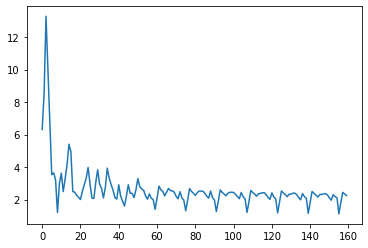

In [121]:
model = GenreClassifier(sr=SR)
optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.NLLLoss()


num_epochs=10
loss_record = []

for epoch in range(num_epochs):
  for batch in dataloader:
    optimizer.zero_grad()
    audio, label = batch
    pred = model(audio)
    loss = loss_function(torch.log(pred+eps), label)
    loss.backward()
    optimizer.step()
    loss_record.append(loss.item())
  # 데이터로더에 있는 모든 데이터 샘플이 한번씩 다 사용됨
plt.plot(loss_record)

In [118]:
# 모델이 업데이트 된 횟수
# 데이터셋 전체가 1000개 
# 배치 사이즈 64
# 한 에폭당 1000//64 +1  번 업데이트
# 10 에폭
len(loss_record), 1000//64 +1 

(160, 16)

In [122]:
label

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

## 4.Get Validation Accuracy
- Define accuracy as a function

## 5. Make train loop with validation


## 6. Let's Train a Better Model
- Goal: get better validation accuracy
- How: Make a function that automate train & validation for given hyperparameters
  - Data Loader
    - batch size
    - shuffle
  - Model
    - hidden size
    - number of layers
    - way to handle multiple frame
    

#### Show progress bar with tqdm
- tqdm.tqdm automatically shows 
  - Caution: the module's name is tqdm and also the function name is tqdm. You have to use `from tqdm import tqdm` or `tqdm.tqdm(range(num_epochs))`

## Linear Model that can see more times